In [ ]:
# !pip install -U scikit-learn mlxtend
# !pip install pyvis

In [2]:
%load_ext autoreload
%autoreload 2
    
%matplotlib inline

#basic data analysis libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pylab as plt
import seaborn as sns

import os, glob
import re
from tqdm import tqdm

from IPython.display  import HTML

%config InlineBackend.figure_format='retina'
np.set_printoptions(precision=4)
pd.options.display.max_rows = 999
pd.options.display.float_format = '{:,.3f}'.format
sns.set_style("whitegrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
agrupamento_bancos_geral = {
    'Nubank': 'Digital',
    'CEF': 'BancoPublico',
    'BB': 'BancoPublico',
    'Itau': 'BancoTradicional',
    'Iti': 'BancoTradicional',
    'PicPay': 'Digital',
    'Original': 'Digital',
    'MercadoPago': 'Digital',
    'Bradesco': 'BancoTradicional',
    'Next': 'BancoTradicional',
    'Santander': 'BancoTradicional',
    'PagBank': 'Digital',
    'Inter': 'Digitais',
    'C6': 'Digitais',
    'XP': 'Investimentos',
    'Pan': 'Financeiras',
    'BTG': 'Investimentos',
    'Safra': 'Investimentos',
    'AgZero': 'Investimentos',
    'BV': 'Financeiras',
    'Crefisa': 'Financeiras',
    'Agibank': 'Financeiras',
    'Daycoval': 'Digitais',
    'Sicredi': 'Cooperativa',
    'Sicoob': 'Cooperativa',
    'Unicred': 'Cooperativa',
    'Digio': 'Digitais',
    'Neon': 'Digitais',
    'Help': 'Digitais',
    'BS2': 'Digitais',
    'Outros': 'Outros'
 }

# loading the data

In [4]:
def drop_cols(df, cols_to_drop):
    cols_to_drop = [c for c in cols_to_drop if c in df.columns];
    if len(cols_to_drop)>0:
        df.drop(columns=cols_to_drop, inplace=True);
    print(f'Colunas atuais {len(df.columns):<4} - Colunas Removidas {len(cols_to_drop):<4}')
    return df;

In [6]:
df_sheets = pd.read_excel('../data/Pesquisa Credito PF - compacta.xlsx', sheet_name=None)
print(df_sheets.keys())

dict_keys(['pesquisa', 'conhece_banco', 'De para colunas', 'Possui_banco', 'Considera contratar no banco', 'produto_por_banco', 'cartoes por banco', 'Questões NPS', 'Questões ranking', 'Questões Booleanas'])


In [7]:
df_cesta_produtos = df_sheets['produto_por_banco']
df_possui_banco = df_sheets['Possui_banco']
df_produto_por_banco = df_sheets['produto_por_banco']
df_cartoes_por_banco = df_sheets['cartoes por banco']
df_considera_contratar_banco = df_sheets['Considera contratar no banco']

df_questoes_nps = df_sheets['Questões NPS']
df_questoes_ranking = df_sheets['Questões ranking']
df_questoes_Booleanas = df_sheets['Questões Booleanas']


In [8]:
def featureProdutos(df):
    return (
        df
        .groupby('id')
        .agg(
            qtd_bancos=('banco','nunique'),
            qtd_investimentos=('produto',lambda x: x.str.contains('investimentos').sum()),
            qtd_imobiliario=('produto',lambda x: x.str.contains('imobiliario').sum()),
            tem_investimentos=('produto',lambda x: x.str.contains('investimentos').max().astype(int)),
            tem_imobiliario=('produto',lambda x: x.str.contains('imobiliario').max().astype(int)),
        )
        .reset_index()
    )

In [9]:
def featureBancosAtuais(df):
    return (
        df
        .assign(categ_banco=lambda x: x['banco'].map(agrupamento_bancos_geral))
        .groupby('id')
        .agg(
            qtd_bancos=('banco','nunique'),
            qtd_categ_bancos=('categ_banco','nunique'),
            qtd_banco_digital=('categ_banco',lambda x: x.str.contains('Digitais').sum()),
            qtd_banco_tradicional=('categ_banco',lambda x: x.str.contains('BancoTradicional').sum()),
            qtd_financeiras=('categ_banco',lambda x: x.str.contains('Financeiras').sum()),
        )
        .reset_index()
    )

In [10]:
df_pesquisa = (
    df_sheets['pesquisa']
    .copy()
    .pipe(drop_cols,['QFEEDBACK','Q13.97','QATT1R88','Q26R88'])
    .merge(featureProdutos(df_cesta_produtos), on='id', how='left')
    .merge(featureBancosAtuais(df_possui_banco), on='id', how='left')
    .assign(train=lambda x: (np.random.RandomState(42).rand(len(x))<=0.6)*1)
    
)

Colunas atuais 82   - Colunas Removidas 4   


In [23]:
np.sort(df_pesquisa['faixa_idade'].drop_duplicates().values)

array([18, 25, 35, 45, 55, 65, 75])

In [31]:
df_pesquisa.head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
id,6679927b-171e-363c-01cf-072780e4c576,667992be-a48a-dc7e-9c7d-41b685799100,667992ac-6427-d699-e9d0-2b48e94ad5df,667992af-8ae6-4375-70d7-0cf58f6c5c80,667992b1-d26f-920a-2919-b46bcc4ddd29
data_resposta,2024-06-24 00:00:00,2024-06-24 00:00:00,2024-06-24 00:00:00,2024-06-24 00:00:00,2024-06-24 00:00:00
genero,Feminino,Masculino,Feminino,Feminino,Feminino
idade,43,46,41,21,22
faixa_idade,35,45,35,18,18
estado,Mato Grosso do Sul,São Paulo,São Paulo,São Paulo,Piauí
regiao,Centro Oeste,Sudeste,Sudeste,Sudeste,Nordeste
capital,Capital,Capital,Região Metropolitana,Interior,Capital
banco_principal,BB,Santander,Itau,PagBank,MercadoPago


In [9]:
df_pesquisa['train'].value_counts(dropna=False)

train
1    948
0    652
Name: count, dtype: int64

In [10]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, KBinsDiscretizer, TargetEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFpr, SelectFromModel, RFE
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV

In [11]:
from sklearn import set_config
set_config(display='diagram', transform_output='pandas')  

In [12]:
def getImportanceDataSet(clf):
    if type(clf) == LogisticRegression or type(clf) == LogisticRegressionCV:
        features = np.hstack([['intercept'], clf.feature_names_in_])
        weights = np.hstack([clf.intercept_, clf.coef_[0]])

        return pd.DataFrame({
            'features':features,
            'coef':weights,
            'weights':np.abs(weights)/np.abs(weights).max()
        }).sort_values('weights', ascending=True)

    if type(clf) == RandomForestClassifier or type(clf) == DecisionTreeClassifier:
        features = clf.feature_names_in_
        weights = clf.feature_importances_

        return pd.DataFrame({
            'features':features,
            'weights':weights
        }).sort_values('weights', ascending=True)
        
    return None

In [13]:
df_pesquisa.columns

Index(['Unnamed: 0', 'id', 'data_resposta', 'genero', 'idade', 'faixa_idade',
       'estado', 'regiao', 'capital', 'banco_principal', 'cartao_loja',
       'default_detalhe', 'default', 'perspectiva_futuro',
       'nivel_suporte_contratacao', 'consistencia_pagamento_cartao',
       'comprometimento_renda_com_parcelas', 'transparencia_comunicacao',
       'tipo_emprego', 'estado_civil', 'escolaridade', 'ano_nascimento',
       'idade_calculada', 'elapsed', 'faixa_renda', 'bancarizado_uso_conta',
       'ind_bancarizado', 'origem_dinheiro_pagamento_contas__salario',
       'origem_dinheiro_pagamento_contas__vender_bens',
       'origem_dinheiro_pagamento_contas__renda_extra',
       'origem_dinheiro_pagamento_contas__vender_ferias',
       'origem_dinheiro_pagamento_contas__reduzo_custo',
       'origem_dinheiro_pagamento_contas__cobro_divida_de_terceiros',
       'origem_dinheiro_pagamento_contas__uso_dinheiro_extra',
       'origem_dinheiro_pagamento_contas__empresto_de_parentes',
  

In [14]:
var = 'fator_mudar_banco__Nada'
(
    df_pesquisa
    .assign(boot=lambda x:(10*np.random.RandomState(42).rand(len(x))).astype(int))
    .pivot_table(index=['boot',var], columns='default', values='id', aggfunc='nunique')
    .reset_index()
    .groupby(var)
    .mean()
    .drop(columns=['boot'])
    .apply(lambda x:x/x.sum(), axis=1)
)

default,Não,Sim
fator_mudar_banco__Nada,,
Não,0.474,0.526
Sim,0.739,0.261


In [15]:
df_pesquisa[['faixa_renda','default','comprometimento_renda_com_parcelas']].apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)


,faixa_renda,default,comprometimento_renda_com_parcelas
faixa_renda,1.000,-0.048,-0.078
default,-0.048,1.000,-0.155
comprometimento_renda_com_parcelas,-0.078,-0.155,1.000


In [16]:
from scipy.stats import chi2_contingency

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [17]:
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.base import BaseEstimator, TransformerMixin

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

class CramersVSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.1):
        self.threshold = threshold
    
    def fit(self, X, y):
        self.selected_features_ = []
        for i in range(X.shape[1]):
            confusion_matrix = pd.crosstab(X.iloc[:, i], y)
            cv = cramers_v(confusion_matrix.values)
            if cv >= self.threshold:
                self.selected_features_.append(i)
        return self
    
    def transform(self, X):
        return X.iloc[:, self.selected_features_]
    
    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y)
        return self.transform(X)


In [18]:
def categ_correlation(df, var1, var2):
    confusion_matrix = pd.crosstab(df[var1], df[var2]).values
    return cramers_v(confusion_matrix)

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

correlations = [{
        'variable':var1,
        'crammerv':categ_correlation(df_pesquisa.query("train == @set_"), var1, 'default'),
        'set_':'train' if set_ == 1 else 'test'
        
    }
    for set_ in [1,0]
    for var1 in df_pesquisa.query("train == @set_").columns
]

In [19]:
(
    pd.DataFrame(correlations)
    .dropna()
    .sort_values('crammerv')
    .pivot_table(index='variable', columns='set_', values='crammerv')
    .sort_values('train', ascending=False)
)

set_,test,train
variable,,
default_detalhe,0.999,0.999
default,0.997,0.998
consistencia_pagamento_cartao,0.207,0.332
faixa_renda,0.157,0.254
fator_mudar_banco__Nada,0.213,0.218
fator_mudar_banco__Credito_aprovado_com_maior_agilidade,0.181,0.216
escolaridade,0.026,0.179
transparencia_comunicacao,0.117,0.161
perspectiva_futuro,0.078,0.149


In [20]:
cramers_v((
    df_pesquisa
    .pivot_table(index=['comprometimento_renda_com_parcelas'], columns='default', values='id', aggfunc='nunique')
).values)

0.16293031574162595

In [21]:
category_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, fill_value='NA', strategy='constant')),
    ('onehot', OneHotEncoder(drop='if_binary',handle_unknown='ignore', sparse_output=False))
])

category_pipeline2 = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, fill_value='NA', strategy='constant')),
    ('onehot', TargetEncoder(random_state=42))
])



vars_onehot = [
    # variáveis comportamentais
    'fator_mudar_banco__Nada',
    'fator_mudar_banco__Credito_aprovado_com_maior_agilidade',
    'origem_dinheiro_pagamento_contas__empresto_de_parentes',

    # variáveis cadastrais
    'escolaridade',
    'nivel_suporte_contratacao',
    

    # variáveis financeiras
    'comprometimento_renda_com_parcelas',
    'tipo_emprego',
    'faixa_renda',
    'faixa_idade',

  
]

vars_target = [
    # 'nivel_suporte_contratacao',

]

vars_passthrough = [
    # 'idade'
]
preprocessing = ColumnTransformer(transformers=[
    ('preproOneHot', category_pipeline, vars_onehot),
    ('preproTarget', category_pipeline2, vars_target),
    ('passthrough', 'passthrough', vars_passthrough),
], remainder='drop')

clf = Pipeline([
    ('prepro',preprocessing),
    # ('selection', SelectFpr()),
    # ('selection',SelectFromModel(estimator=LogisticRegression(solver='newton-cg',random_state=42))),
    # ('selection',RFE(estimator=LogisticRegressionCV(Cs=[1e6,1e6,1e6],solver='newton-cg',random_state=42), n_features_to_select=35, step=1)),
    
    # ('clf', DecisionTreeClassifier(min_samples_leaf=0.05,min_samples_split=0.02, random_state=42))
    # ('clf', LogisticRegression(C=1e6,solver='newton-cg',random_state=42)),
    ('clf', LogisticRegressionCV(Cs=[1e6,1e6,1e6],solver='newton-cg',random_state=42)),
    # ('clf', CalibratedClassifierCV(RandomForestClassifier(min_samples_leaf=0.01, random_state=42))),
    # ('clf', HistGradientBoostingClassifier(random_state=42)),
])


In [22]:
clf.fit(
    df_pesquisa.query("ind_bancarizado == 'Bancarizado' and train==1"),
    df_pesquisa.query("ind_bancarizado == 'Bancarizado' and train==1")['default']
)

display(clf)

try:
    display(
        getImportanceDataSet(clf['clf'])
        .sort_values('coef')
        .assign(features=lambda x:x['features'].str.replace('preproOneHot',' '))
        .assign(features=lambda x:x['features'].str.replace('_',' '))
        .style
        .format(precision=4)
        .bar()
    )
except:
    pass;

Pipeline(steps=[('prepro',
                 ColumnTransformer(transformers=[('preproOneHot',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['fator_mudar_banco__Nada',
                                                   'fator_mudar_banco__Credito_aprovado_com_maior_agilidade',
                                                   'origem_dinheiro_pagame...
                                                   'comprometimento_renda_com_parcelas',
                                                   'tipo_emprego',
                                                   'faixa_renda',
                                                   'faixa_idade']),
                                                 ('preproTarget',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='NA',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   TargetEncoder(random_state=42))]),
                                                  []),
                                                 ('passthrough', 'passthrough',
                                                  [])])),
                ('clf',
                 LogisticRegressionCV(Cs=[1000000.0, 1000000.0, 1000000.0],
                                      random_state=42, solver='newton-cg'))])

,features,coef,weights
4,escolaridade NA,-3.6804,1.0000
31,faixa renda 12.708 a 14.120,-2.0614,0.5601
20,tipo emprego Aposentado,-1.4485,0.3936
42,faixa idade 18,-0.9215,0.2504
19,comprometimento renda com parcelas NA,-0.8701,0.2364
32,faixa renda 14.120 a 15.532,-0.7146,0.1942
1,fator mudar banco Nada Sim,-0.6670,0.1812
41,faixa renda Mais 15.532,-0.6132,0.1666
30,faixa renda 11.297 a 12.708,-0.3545,0.0963
24,tipo emprego Empregado tempo integral),-0.3156,0.0857


In [23]:
proba = clf.predict_proba(df_pesquisa)[:,1]

scorer = KBinsDiscretizer(n_bins=10, strategy='quantile', encode='ordinal')

df_pesquisa = (
    df_pesquisa
    .assign(proba=proba)
    .assign(score=scorer.fit_transform(proba.reshape(-1,1)))
    .astype({'score':int})
)

In [24]:
model_report = (
    df_pesquisa
    .assign(target=lambda x:(x['default']=='Sim')*1)
    .query('train==0')
    .groupby('score')
    .agg(
        proba=('proba','mean'),
        tx_target=('target','mean'),
        nrows=('id','nunique'),
        target=('target','sum'),
    )
    .assign(nontarget=lambda x:x['nrows']-x['target'])
    .assign(pct_pop=lambda x:x['nrows']/x['nrows'].sum())
    .assign(pct_target=lambda x:x['target']/x['target'].sum())
    .assign(pct_nontarget=lambda x:x['nontarget']/x['nontarget'].sum())
    .assign(pct_target_acm=lambda x:x['pct_target'].cumsum())
    .assign(pct_nontarget_acm=lambda x:x['pct_nontarget'].cumsum())
    .assign(odds=lambda x:x['pct_target']/x['pct_nontarget'])
    .assign(ks=lambda x:np.abs(x['pct_target_acm']-x['pct_nontarget_acm']))
    .assign(proba=lambda x:np.round(x['proba'],2))
)

,proba,tx_target,nrows,target,nontarget,pct_pop,pct_target,pct_nontarget,pct_target_acm,pct_nontarget_acm,odds,ks
score,,,,,,,,,,,,
0,9.0%,25.0%,64,16,48,9.8%,5.3%,13.8%,5.3%,13.8%,0.38,8.5%
1,17.0%,26.9%,52,14,38,8.0%,4.6%,10.9%,9.9%,24.6%,0.42,14.7%
2,25.0%,30.3%,76,23,53,11.7%,7.6%,15.2%,17.5%,39.8%,0.50,22.3%
3,33.0%,38.6%,70,27,43,10.7%,8.9%,12.3%,26.4%,52.1%,0.72,25.7%
4,41.0%,41.8%,67,28,39,10.3%,9.2%,11.2%,35.6%,63.3%,0.83,27.7%
5,50.0%,60.0%,50,30,20,7.7%,9.9%,5.7%,45.5%,69.1%,1.73,23.5%
6,58.0%,43.1%,72,31,41,11.0%,10.2%,11.7%,55.8%,80.8%,0.87,25.0%
7,67.0%,49.2%,61,30,31,9.4%,9.9%,8.9%,65.7%,89.7%,1.11,24.0%
8,76.0%,68.9%,74,51,23,11.3%,16.8%,6.6%,82.5%,96.3%,2.55,13.8%


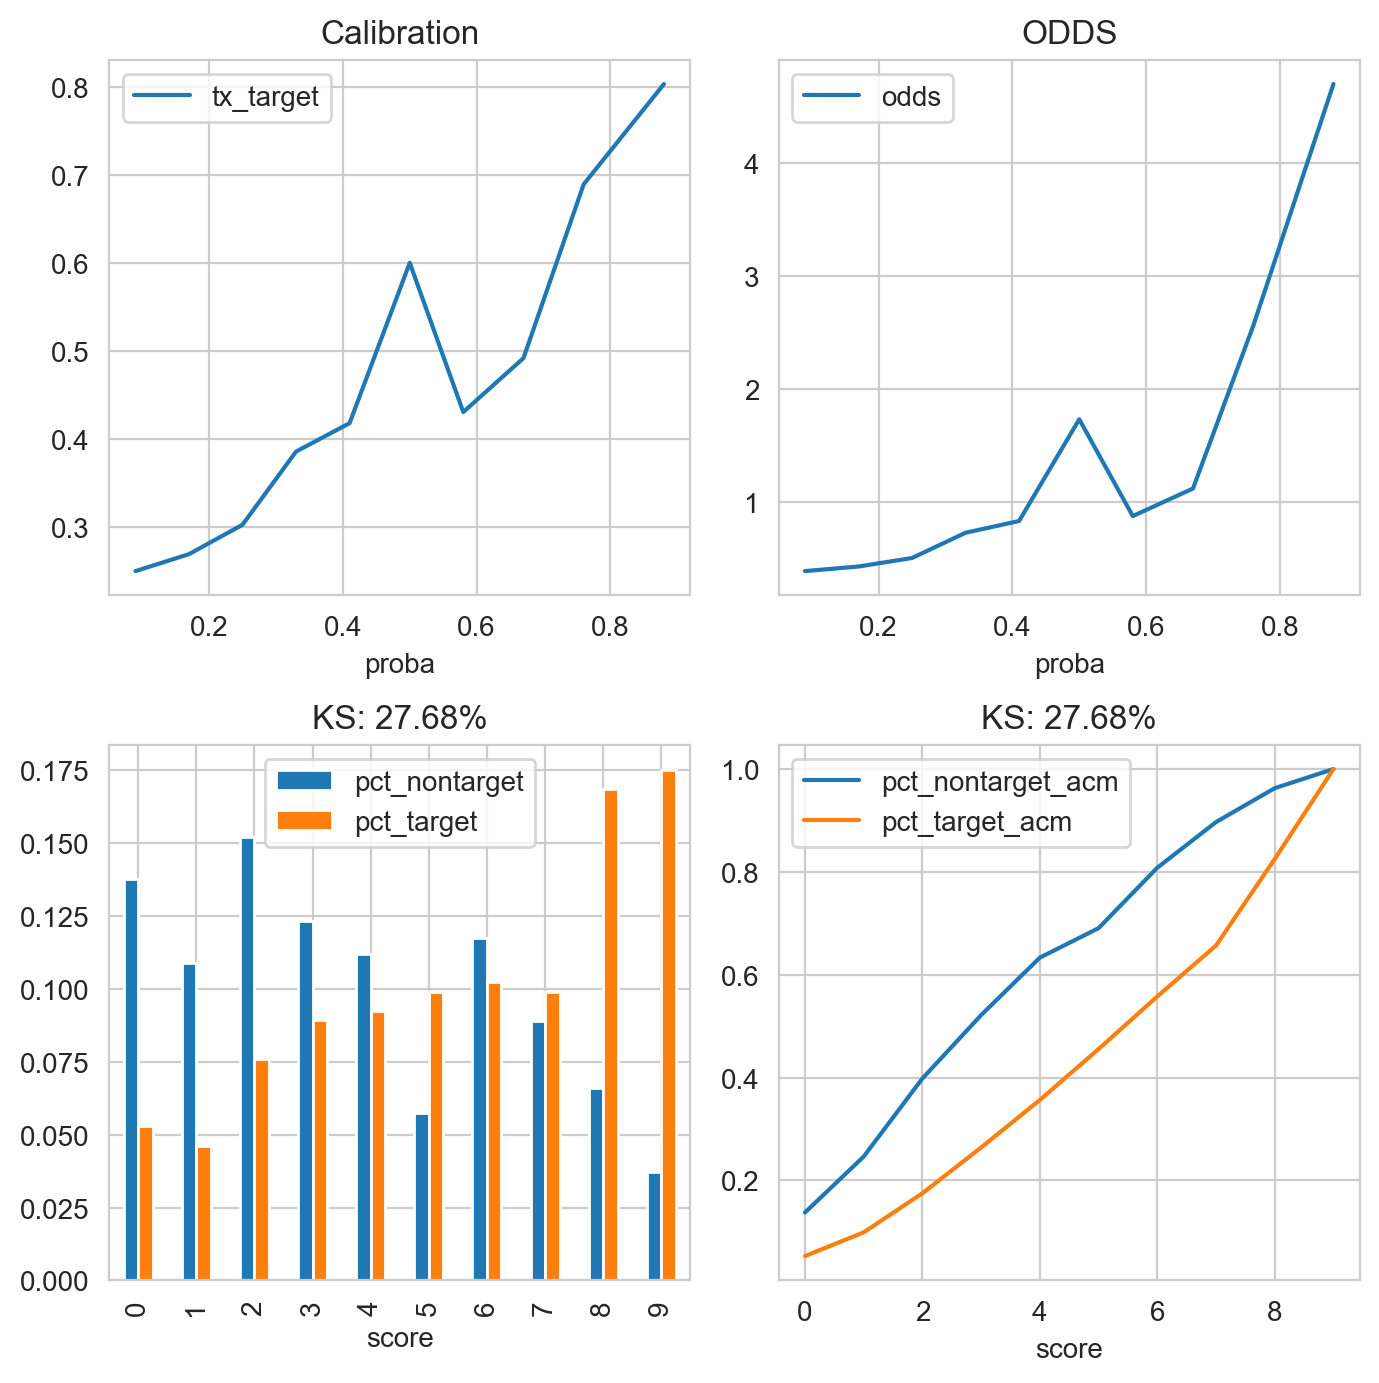

In [25]:
display((
    model_report
    .style
    .format('{:.1%}', subset=['proba', 'tx_target', 'pct_pop', 'pct_target', 'pct_nontarget', 'pct_target_acm', 'pct_nontarget_acm', 'ks'])
    .format('{:.2f}', subset=['odds'])
    .highlight_max(subset=['ks'])
    .background_gradient(subset=['tx_target'], cmap='Oranges')
    .background_gradient(subset=['proba'], cmap='Reds')
    
))
def plotter(df, plotfunc):
    plotfunc(df)
    return df;

fig, axs = plt.subplots(2,2, figsize=(7,7))
axs = axs.flatten().tolist()
    
(
    model_report
    .pipe(plotter, lambda df:df.plot(x='proba',y='tx_target', title=f'Calibration', ax=axs.pop(0)))
    .pipe(plotter, lambda df:df.plot(x='proba',y='odds', title=f'ODDS', ax=axs.pop(0)))
    .pipe(plotter, lambda df:df.plot(kind='bar',y=['pct_nontarget','pct_target'], title=f'KS: {df['ks'].max():0.2%}', ax=axs.pop(0)))
    .pipe(plotter, lambda df:df.plot(y=['pct_nontarget_acm','pct_target_acm'], title=f'KS: {df['ks'].max():0.2%}', ax=axs.pop(0)))
    
)

while len(axs)>0:fig.delaxes(axs.pop(0))

plt.tight_layout()

# Funçoes uteis

In [26]:
def getAssociationRules(df,min_support=0.05, min_threshold=2):
    from mlxtend.frequent_patterns import apriori, fpgrowth
    from mlxtend.frequent_patterns import association_rules

    # Convert the dataframe into a binary matrix
    df_binary = df.applymap(lambda x: 1 if x > 0 else 0)

    # Find frequent itemsets using Apriori algorithm
    frequent_itemsets = apriori(df_binary, min_support=min_support, use_colnames=True)

    # Generate association rules
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=2)

    # Sort the rules by lift in descending order
    rules = rules.sort_values(by='lift', ascending=False)
    rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
    rules["consequent_len"] = rules["consequents"].apply(lambda x: len(x))

    return frequent_itemsets, rules

# Modelo de associação produtos

In [27]:
df_cesta_produtos = (
    pd.read_excel('Pesquisa Credito PF - compacta.xlsx', sheet_name='produto_por_banco')
)

In [28]:
df_produtos_basket = (
    df_cesta_produtos
    # .assign(banco=lambda x:x['banco'].map(agrupamento_bancos))
    .assign(peso=1)
    .query('produto != "conta poupanca"')
    .pivot_table(index=['id','banco'], columns='produto', values='peso', aggfunc='max', fill_value=0)
    .reset_index()
    .drop(columns=['banco'])
    .set_index('id')
)
df_produtos_basket.sum().to_frame('qtd').sort_values('qtd', ascending=False)

,qtd
produto,
cartao de credito,3043
investimentos,988
cheque especial,753
credito pessoal,575
seguros,443
crypto,412
consig privado,354
consig publico,300
credito imobiliario,288


In [29]:

apriori_rules = getAssociationRules(df_produtos_basket, min_support=0.001, min_threshold=2)[1]
apriori_rules['lhs_items'] = apriori_rules['antecedents'].apply(lambda x:len(x) )
apriori_rules['rhs_items'] = apriori_rules['consequents'].apply(lambda x:len(x) )
apriori_rules[apriori_rules['lhs_items']>1].sort_values('lift', ascending=False).head()
apriori_rules['antecedents_'] = apriori_rules['antecedents'].apply(lambda a: ','.join(list(a)))
apriori_rules['consequents_'] = apriori_rules['consequents'].apply(lambda a: ','.join(list(a)))
pivot = apriori_rules[apriori_rules['lhs_items']>1].pivot(index = 'antecedents_', columns = 'consequents_', values= 'lift')
sns.heatmap(pivot, annot = True, cmap='coolwarm', fmt=".2f")
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

/opt/anaconda3/envs/GeralTestes/lib/python3.12/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import plotly.graph_objects as go

# Define the CSV data
data = """
stage1;stage2;count
banana;apple;10
banana;pear;5
pear;apple;5
apple;banana;7
pear;banana;2
"""

# Read the data into a pandas DataFrame
from io import StringIO
df = pd.read_csv(StringIO(data), delimiter=';')

# Create a list of all unique labels
stage1_labels = {label:i for i, label in enumerate(sorted(list(df['stage1'].unique())))}
label_offset = len(stage1_labels)
stage2_labels = {label:i+label_offset for i, label in enumerate(sorted(list(df['stage2'].unique())))}
all_labels = {**{v:k for k,v in stage1_labels.items()}, **{v:k for k,v in stage2_labels.items()}}

print([all_labels[i] for i in range(len(all_labels))])



# # Extract source, target, and value
sources = df['stage1'].map(stage1_labels).tolist()
targets = df['stage2'].map(stage2_labels).tolist()
values = df['count'].tolist()

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=[all_labels[i] for i in range(len(all_labels))],
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
    )
)])

fig.update_layout(title_text="Sankey Diagram of Meal Stages", font_size=10)
fig.show()


In [ ]:
from PyARMViz import PyARMViz
from PyARMViz.Rule import generate_rule_from_dict

apriori_vis = apriori_rules.copy()

apriori_vis['uni'] = np.nan
apriori_vis['ant'] = np.nan
apriori_vis['con'] = np.nan
apriori_vis['tot'] = 20507

transactions = [a[1]['Item'].tolist() for a in list(data.groupby(['Transaction', 'date_time']))]

def tran():
    for t in transactions:
        yield t
def antec(x):
    cnt = 0
    for t in tran():
        t = set(t)
        if x.intersection(t) == x:
            cnt = cnt + 1
    return cnt
vis = apriori_vis.values.tolist()

rules_dict = []
for i in vis:
    i[10] = antec(i[0])
    i[11] = antec(i[1])
    i[9] = antec(i[0].union(i[1]))
    diction = {
        'lhs': tuple(i[0]), 
        'rhs': tuple(i[1]),
        'count_full': i[9],
        'count_lhs': i[10],
        'count_rhs': i[11],
        'num_transactions': i[12]
    }
    rules_dict.append(diction)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score


# Initialize variables to store the best model and silhouette score
metrics = []

# Iterate over different cluster numbers
for k in [2,3,5,7,10,12,15,20,25,30,35,40,45,50]:
    # Create a KMeans model with k clusters
    model = Pipeline([
        # ('pca', PCA(n_components=2, random_state=42)),
        ('kmeans', KMeans(n_clusters=k, random_state=42)),
    ])
    
    
    # Fit the model to the data
    model.fit(df_produtos_basket)
    
    # Calculate the silhouette score
    score = silhouette_score(df_produtos_basket, model['kmeans'].labels_, sample_size=600, random_state=42)

    metrics.append({'k':k, 'score':score, 'model':model})

In [ ]:
pd.DataFrame(metrics).sort_values('k', ascending=True).set_index('k')['score'].plot()

In [ ]:
model = [m for m in metrics if m['k']==10][0]['model']['kmeans']

def sort_cols(df):
    df = df.sort_values(df.columns.tolist(), ascending=True)
    df = df.T
    df.sort_values(df.columns.tolist(), ascending=True)

    return df.T

sns.clustermap(
    df_produtos_basket
    .assign(cluster=model.predict(df_produtos_basket))
    # .assign(peso=1)
    .groupby('cluster')
    .mean()
    .apply(lambda x:(100*x/x.sum()), axis=1)
    .astype(int)
    .pipe(sort_cols)
    .T
    #.style
    # .format('{:.2%}')
    #.background_gradient(cmap='Blues')
    , cmap='Blues'
    , annot=True
)


In [ ]:
def pca_plot(df):
    pca = PCA(n_components=2, random_state=42)
    pca.fit(df)
    df_pca = pca.transform(df)
    return df_pca

def cluster_plot(df):
    from sklearn.cluster import AgglomerativeClustering
    model = AgglomerativeClustering(n_clusters=11)
    model.fit(df)
    order = np.argsort(model.labels_)
    return df.iloc[order,order]

(
    df_produtos_basket
    .assign(cluster=model.predict(df_produtos_basket))
    .groupby('cluster')
    .sum()
    .apply(lambda x:(100*x/x.sum()), axis=1)
    # .corr()
    # # .pipe(pca_plot)
    # # .plot(x='pca0', y='pca1', kind='scatter',  cmap='viridis', colorbar=False)
    # .pipe(cluster_plot)
    # .style
    # .format('{:.0%}')
    # .background_gradient(cmap='coolwarm_r')
)

In [ ]:
edgelist = []
df_produtos_basket.groupby('id').apply(lambda x:edgelist.append(list(x.columns[x.values[0]==1])))
edgelist = [e for e in edgelist if len(e)>1]

edgelist = [
    (e[i],e[j])
    for e in edgelist
    for i in range(len(e))
    for j in range(i+1, len(e))
]

edgelist = [
    sorted(e) for e in edgelist
]

In [ ]:
edgelist_df = (
    pd.DataFrame(edgelist, columns=['source','target'])
    .groupby(['source','target']).size()
    .to_frame('weight').reset_index()
    .sort_values('weight', ascending=False)
    .query('weight>10')
)

edgelist_df.head(5)

In [ ]:
from pyvis.network import Network
import pandas as pd

net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")

# set the physics layout of the network
net.barnes_hut()

def buildNetwork(row):
    src = row['source']
    dst = row['target']
    w = row['weight']

    net.add_node(src, src, title=src)
    net.add_node(dst, dst, title=dst)
    net.add_edge(src, dst, value=w)

edgelist_df.apply(buildNetwork, axis=1)

neighbor_map = net.get_adj_list()

# add neighbor data to node hover data
for node in net.nodes:
    node["title"] += " Neighbors:<br>" + "<br>\n".join(neighbor_map[node["id"]])
    node["value"] = len(neighbor_map[node["id"]])

net.show("productsNetwork.html", notebook=False)

In [ ]:
frequent_itemsets, rules = getAssociationRules(df_produtos_basket)

In [ ]:
rules

In [ ]:
#Prepare data for heatmap
heatmap_data = rules.pivot_table(index="antecedents", columns="consequents", values="lift").fillna(0)

# Convert frozensets to strings for better readability
heatmap_data.index = heatmap_data.index.map(lambda x: ',\n'.join(list(x)))
heatmap_data.columns = heatmap_data.columns.map(lambda x: ',\n'.join(list(x)))

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.clustermap(heatmap_data, annot=True, cmap="YlGnBu")
plt.title('Association Rules Heatmap')
plt.show()

# Modelo de associação

In [ ]:
df_cesta_bancos = (
    pd.read_excel('Pesquisa Credito PF - compacta.xlsx', sheet_name='Possui_banco')
    .pipe(drop_cols,['QFEEDBACK','Q13.97','QATT1R88','Q26R88'])
)

In [ ]:
agrupamento_bancos = {
    'Nubank': 'Nubank',
    'CEF': 'BancoPublico',
    'BB': 'BancoPublico',
    'Itau': 'Itau',
    'Iti': 'Itau',
    'PicPay': 'PicPayOriginal',
    'Original': 'PicPayOriginal',
    'MercadoPago': 'MercadoPago',
    'Bradesco': 'Bradesco',
    'Next': 'Bradesco',
    'Santander': 'Santander',
    'PagBank': 'PagBank',
    'Inter': 'Inter',
    'C6': 'Digitais',
    'XP': 'Investimentos',
    'Pan': 'Financeiras',
    'BTG': 'Investimentos',
    'Safra': 'Investimentos',
    'AgZero': 'Investimentos',
    'BV': 'Financeiras',
    
    
    'Crefisa': 'Financeiras',
    'Agibank': 'Financeiras',
    'Daycoval': 'Outros',
    'Sicredi': 'Cooperativa',
    'Sicoob': 'Cooperativa',
    'Unicred': 'Cooperativa',
    'Digio': 'Digitais',
    'Neon': 'Digitais',
    'Help': 'Outros',
    'BS2': 'Outros',
    'Outros': 'Outros'
 }

In [ ]:
df_cesta_bancos['banco'].map(agrupamento_bancos).value_counts(normalize=True)

In [ ]:
df_bank_basket = (
    df_cesta_bancos
    .assign(banco=lambda x:x['banco'].map(agrupamento_bancos))
    .assign(peso=1)
    .pivot_table(index='id', columns='banco', values='peso', fill_value=0)
)

In [ ]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Convert the dataframe into a binary matrix
df_binary = df_bank_basket.applymap(lambda x: 1 if x > 0 else 0)

# Find frequent itemsets using Apriori algorithm
frequent_itemsets = apriori(df_binary, min_support=0.05, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=2)

# Sort the rules by lift in descending order
rules = rules.sort_values(by='lift', ascending=False)

# Display the top 10 rules
top_10_rules = rules.head(50)
display(top_10_rules)

In [ ]:
#Customizable function to change the lift and confidence
def rules_mod(df_rules,lift,confidence):
    '''rules_mod is a function to control the rules 
    based on lift and confidence threshold'''
    
    return df_rules[ (df_rules['lift'] >= lift) &
      (df_rules['confidence'] >= confidence) ]

#Calling function
# rules_mod(top_10_rules, 0.7,0.2)

In [ ]:
edgelist = []

# listing nodes
(
    df_cesta_bancos
    .assign(banco=lambda x:x['banco'].map(agrupamento_bancos))
    .groupby('id')
    .apply(lambda x:edgelist.extend([(x['banco'].iloc[i],x['banco'].iloc[j]) for i in range(len(x)) for j in range(i+1,len(x))]))
)

# sorting edge nodes: source < target
edgelist = [sorted(e) for e in edgelist]
edgelist = (
    pd.DataFrame(edgelist, columns=['source','target'])
    .groupby(['source','target'])
    .size().reset_index()
    .rename(columns={0:'weight'})
    .query('weight > 10')
    .sort_values('weight', ascending=False)
    # .head(100)
)

In [ ]:
edgelist.pivot_table(index='source', columns='target', values='weight', fill_value=0).astype(int)

In [ ]:
edgelist_filtered = (
    edgelist
    #.query('weight > 10')
    .merge(
        edgelist.groupby('source').agg(weight_out=('weight','sum')).reset_index(),
        on='source'
    )
    .merge(
        edgelist.groupby('target').agg(weight_in=('weight','sum')).reset_index(),
        on='target'
    )
    .assign(weight_pct=lambda x:x['weight']/x[['weight_in','weight_out']].max(axis=1))
    .sort_values('weight_pct', ascending=False)
    .head(100)

)


In [ ]:
import networkx as nx

G = nx.from_pandas_edgelist(edgelist_filtered, edge_attr=True)
edgewidth = [G.get_edge_data(u, v)['weight']/70 for u, v in G.edges()]

# Plot the weighted graph
plt.figure(figsize=(10,10))
pos = nx.circular_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500, label=True)
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
nx.draw_networkx_labels(G, pos, font_size=14, bbox=label_options)
nx.draw_networkx_edges(G, pos, width=edgewidth, edge_color='gray')
# nx.draw_networkx_edge_labels(G, pos,  font_size=8)
plt.axis('off')
plt.show()

In [ ]:
pd.DataFrame(dict(nx.degree(G,weight='weight')).items(), columns=['node','degree']).sort_values('degree', ascending=False)